In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import math

## Importing the drivingProfile

In [64]:
drivingProfile = pd.read_csv('./parameter.csv')

In [65]:
drivingProfile

,m,lf,lr,Cf,Cr,Iz,mu,steering_ratio,Sampling Period
0,1331,0.84,1.63,90624,90624,1500,0.5,0.0625,0.04


In [66]:
m = drivingProfile['m'][0]
lf = drivingProfile['lf'][0]
lr = drivingProfile['lr'][0]
Cf = drivingProfile['Cf'][0]
Cr = drivingProfile['Cr'][0]
Iz = drivingProfile['Iz'][0]
steering_ratio = drivingProfile['steering_ratio'][0]
Ts = drivingProfile['Sampling Period'][0]

## Importing inputs

In [67]:
inputs = pd.read_csv('./VDA_input.csv')
inputs.head()

,samplingTime,Drv_DeltaSteer,Veh_Vx
0,0.000,0.0,22.222222
1,0.005,0.0,22.222032
2,0.010,0.0,22.221512
3,0.015,0.0,22.220722
4,0.020,0.0,22.219725


In [68]:
Time = inputs['samplingTime'].to_numpy()

print(Time)
print(len(Time))

deltaSteer = inputs['Drv_DeltaSteer'].to_numpy()

print(deltaSteer)
print(len(deltaSteer))

Vx = inputs['Veh_Vx'].to_numpy()

print(Vx)
print(len(Vx))

[0.000e+00 5.000e-03 1.000e-02 ... 8.990e+00 8.995e+00 9.000e+00]
1801
[ 0.          0.          0.         ... -4.12588952 -3.94726259
 -3.76997935]
1801
[22.22222222 22.22203158 22.22151244 ... 22.18808309 22.18763805
 22.1872213 ]
1801


In [69]:
n = math.floor(Ts/(Time[1]-Time[0]))
n

8

In [70]:
time = [Time[i] for i in range(len(Time)) if i%n==0]
steeringAngle = [deltaSteer[i] for i in range(len(deltaSteer)) if i%n==0]
velocity = [Vx[i] for i in range(len(Vx)) if i%n==0]

## Function to calculate parameters

In [71]:
def calculate_parameters(v_x):
  A = np.array([[(-2*Cf-2*Cr)/(m*v_x), -1-((2*Cf*lf - 2*Cr*lr)/(m*v_x*v_x))], [((2*Cr*lr)-(2*Cf*lf))/Iz, (-2*Cf*lf*lf-2*Cr*lr*lr)/(Iz*v_x)]])
  B = np.array([[(2*Cf)/(m*v_x), 0], [(2*Cf*lf)/Iz, 1/Iz]])
  C = np.array([[0, 1], [(-2*Cf-2*Cr)/m, -(2*Cf*lf-2*Cr*lr)/(m*v_x)]])
  D = np.array([[0, 0], [(2*Cf)/m, 0]])

  return [A, B, C, D]

## Controller Gain K

In [72]:
K = np.array([[1.8639, -0.0279],[-542794.8896, 32604.6225]])

## Observer Gain L

In [73]:
L = np.array([[-0.000000000009229, -0.000000000131049],[0.000000000135782, 0.000000001407986]])

## Matrix P
Positive definite P such that:  
![](./Screenshot%202023-05-30%20104347.png)  
`Amin, Amax` => Discrete-time closed loop matrices derived using the system equations fror v = vmin and v = vmax respectively.

In [74]:
P = np.array([[2, 1],[1,1]])
P

array([[2, 1],
       [1, 1]])

## Evaluating the system

In [75]:
u = [np.transpose(np.array([[deltaSteer[0]*math.pi/180, 0]]))]
x = [np.dot(np.linalg.inv(-K), u[0])]
x_cap = [np.dot(np.linalg.inv(-K), u[0])]
A, B, C, D = calculate_parameters(max(Vx))
y = [np.dot(C,x[0])]
y_cap = [np.dot(C,x_cap[0])]

for i in range(1, len(velocity)):
  A, B, C, D = calculate_parameters(velocity[i-1])

  out = signal.StateSpace(A, B, C, D)
  out = out.to_discrete(Ts)

  r = y[i-1] - y_cap[i-1]

  x.append(np.array(np.dot(out.A, x[i-1])+np.dot(out.B, u[i-1])))
  x_cap.append(np.array(np.dot(out.A, x[i-1])+np.dot(out.B, u[i-1]))+np.dot(L,r))

  y.append(np.dot(out.C, x[i-1])+np.dot(out.D, u[i-1]))
  y_cap.append(np.dot(out.C, x_cap[i-1])+np.dot(out.D, u[i-1]))

  utemp = np.dot(-K, x[i])
  utemp[0][0] += steeringAngle[i]*(math.pi/180)*steering_ratio
  u.append(utemp)

## Extracting the values from the lists

### Extracting `yaw moment -> Mz` and `steering angle -> beta` from `u[]`

In [76]:
Mz = []
delta = []
for i in range(len(u)):
    Mz.append(u[i][1][0])
    delta.append(u[i][0][0])
print(len(Mz), len(delta))
print(Mz)
print(delta)

226 226
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.7064965171616282, -16.4896282246556, -63.567320760342376, -144.09175299621293, -260.37285370524603, -414.0701526520769, -599.1832353556994, -812.2737119571218, -1051.4131184458827, -1315.0121112892882, -1602.2272515340185, -1911.9845304973956, -2373.279067643523, -3190.252212741792, -4204.664751422681, -5219.554226705748, -6218.270668507722, -7167.507263363054, -7256.563442994051, -6641.341646818929, -5962.590733481341, -5272.72924982671, -4601.82882628387, -3992.4102345794395, -3227.024347716223, -2288.419631581641, -1338.8889209059741, -395.61941388898003, 550.262070710932, 1504.38884

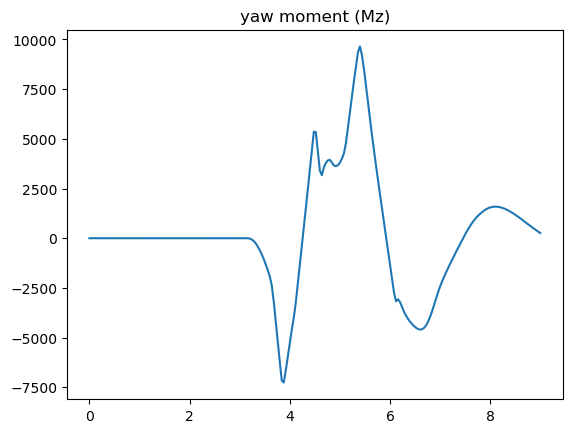

Text(0.5, 1.0, 'steering angle (delta)')

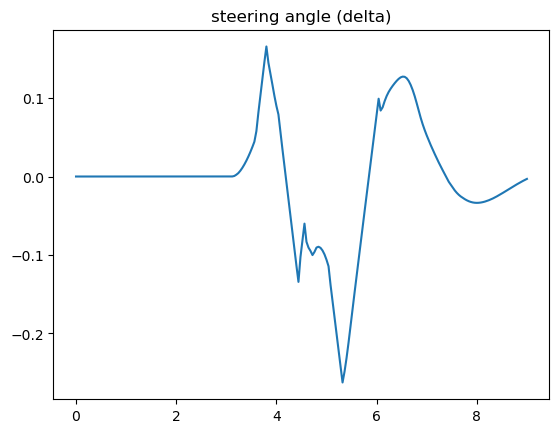

In [77]:
plt.plot(time, Mz)
plt.title("yaw moment (Mz)")
plt.show()
plt.plot(time, delta)
plt.title("steering angle (delta)")

### Extracting `sideslip angle -> beta` and `yaw rate -> r` from `x[] and x_cap[]`

In [78]:
'''
0 -> beta
1 -> r
'''
r = []
beta = []

for i in range(len(x)):
    r.append(x[i][1][0])
    beta.append(x[i][0][0])

print(len(beta), len(r))
print(beta)
print(r)

226 226
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2166035258673958e-05, 0.00010859273110379196, 0.0003731599466758491, 0.000752232050500458, 0.0013017052261635885, 0.001992330346063386, 0.002802985270550704, 0.003725071984771876, 0.0047518100810381375, 0.005877893676194665, 0.007102775577457075, 0.008421466682984687, 0.010764687569504501, 0.014928016459000232, 0.01923298056035745, 0.023546465215570578, 0.027880904284050132, 0.032009778052401364, 0.02998201048910407, 0.027344949776751497, 0.0245558963063145, 0.021718709362780194, 0.019104827536634676, 0.016884259573750702, 0.012967322968688477, 0.008618478561395096, 0.004210332923223651,

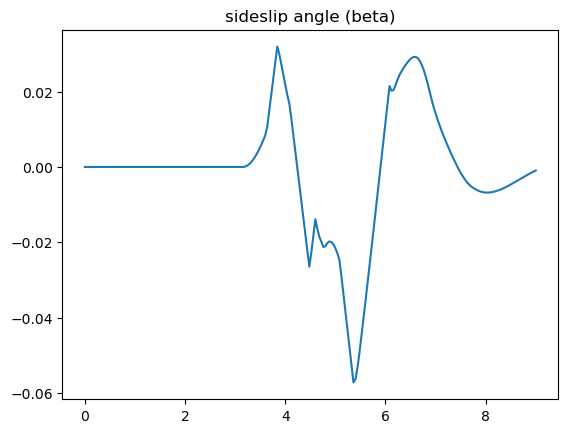

Text(0.5, 1.0, 'yaw rate (r)')

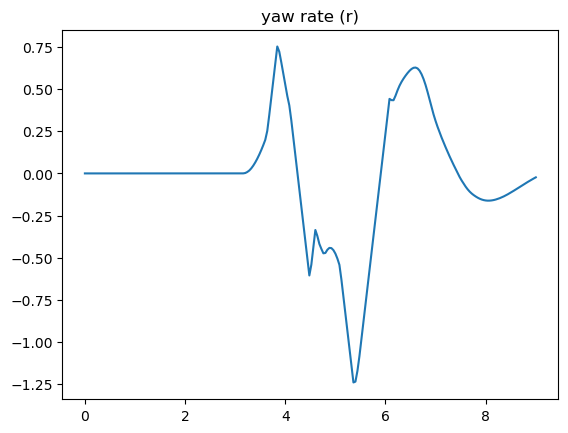

In [79]:
plt.plot(time, beta)
plt.title("sideslip angle (beta)")
plt.show()
plt.plot(time, r)
plt.title("yaw rate (r)")

In [80]:
'''
0 -> beta
1 -> r
'''
r_cap = []
beta_cap = []

for i in range(len(x)):
    r_cap.append(x_cap[i][1][0])
    beta_cap.append(x_cap[i][0][0])

print(len(beta_cap), len(r_cap))
print(beta_cap)
print(r_cap)

226 226
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2166035258673958e-05, 0.00010859273110379196, 0.0003731599466758491, 0.000752232050500458, 0.0013017052261635885, 0.001992330346063386, 0.002802985270550704, 0.003725071984771876, 0.0047518100810381375, 0.005877893676194665, 0.007102775577457075, 0.008421466682984687, 0.010764687569504501, 0.014928016459000232, 0.01923298056035745, 0.023546465215570578, 0.027880904284050132, 0.032009778052401364, 0.02998201048910407, 0.027344949776751497, 0.0245558963063145, 0.021718709362780194, 0.019104827536634676, 0.016884259573750702, 0.012967322968688477, 0.008618478561395096, 0.004210332923223651,

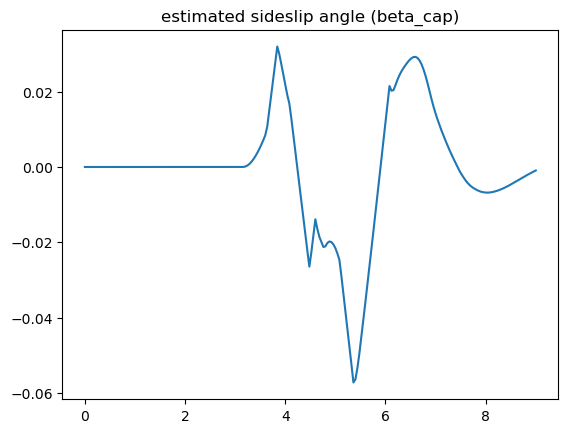

Text(0.5, 1.0, 'estaimated yaw rate (r_cap)')

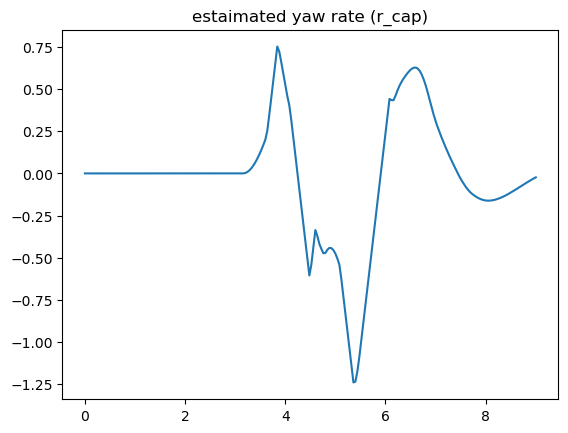

In [81]:
plt.plot(time, beta)
plt.title("estimated sideslip angle (beta_cap)")
plt.show()
plt.plot(time, r)
plt.title("estaimated yaw rate (r_cap)")

### Extracting `yaw rate -> r` and `inertial acceleration -> ay` from `y[] and y_cap[]`

In [82]:
'''
0 -> r
1 -> ay
'''
r1 = []
ay = []

for i in range(len(y)):
    r1.append(y[i][0][0])
    ay.append(y[i][1][0])

print(len(r1), len(ay))
print(r1)
print(ay)

226 226
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025487669063683425, 0.0023135740251401726, 0.008161929579752128, 0.016942366555576304, 0.02965627951166906, 0.04586763373476513, 0.06504075659317002, 0.08692705301781749, 0.11135449725826899, 0.13818601213186593, 0.16738661939586658, 0.198840321152565, 0.25199790209229417, 0.3463650977266124, 0.4491457710133233, 0.5520829205693647, 0.6548728797984666, 0.7527230596654433, 0.7216966096268508, 0.6589262194956651, 0.5916770162910602, 0.5232857304405678, 0.45919352631236654, 0.4035348069400648, 0.31485170505847837, 0.21366558532717436, 0.11115712550103596, 0.00855233034588132, -0.09413

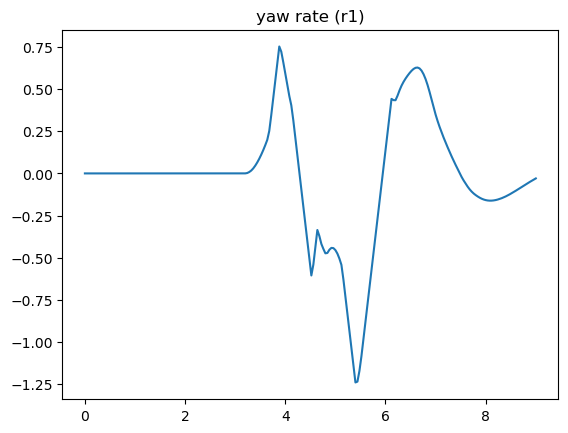

Text(0.5, 1.0, 'inertial acceleration (ay)')

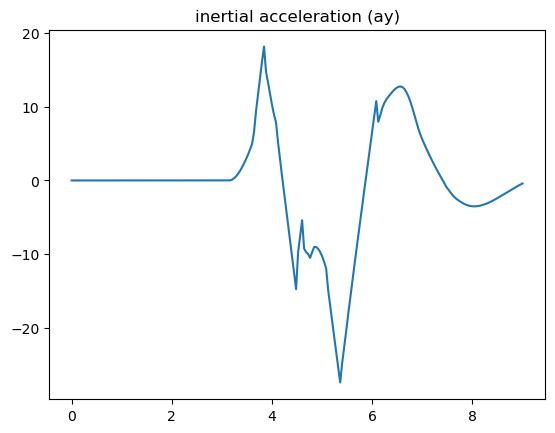

In [83]:
plt.plot(time, r1)
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time, ay)
plt.title("inertial acceleration (ay)")

In [84]:
'''
0 -> r1
1 -> ay
'''
r1_cap = []
ay_cap = []

for i in range(len(y_cap)):
    r1_cap.append(y_cap[i][1][0])
    ay_cap.append(y_cap[i][0][0])

print(len(r1_cap), len(ay_cap))
print(r1_cap)
print(ay_cap)

226 226
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01106506507458657, 0.0937179346452472, 0.2947862479594697, 0.5333627916778444, 0.8856644118712526, 1.2998979171968967, 1.7710433641396024, 2.298912916829829, 2.8800313181178847, 3.5119146333558247, 4.195781634155015, 4.926783763222862, 6.552304852990087, 9.405876113457282, 11.66049826206054, 13.915139320666386, 16.168625892412088, 18.201454924598792, 14.748504314101284, 13.300833515265406, 11.760698270274101, 10.23340306325159, 8.921126066714592, 7.855894129879037, 5.136287991661764, 2.7979001776164094, 0.5716213270016217, -1.6372822741548902, -3.8383335383677735, -6.039179392635039, -8.

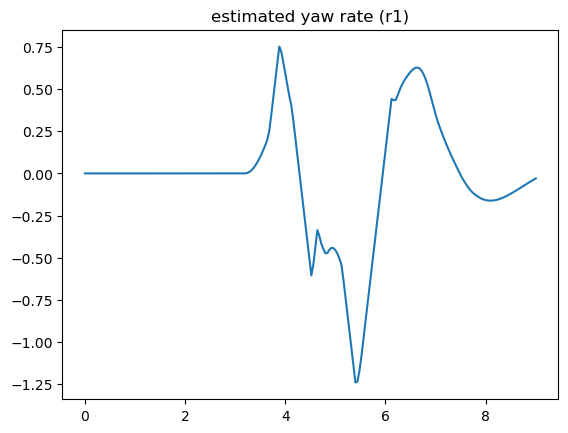

Text(0.5, 1.0, 'estimated inertial acceleration (ay)')

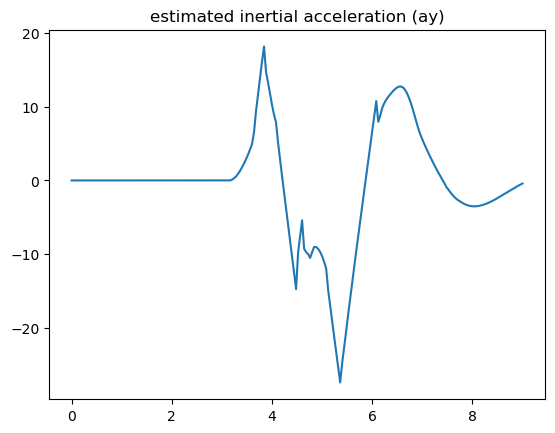

In [85]:
plt.plot(time, r1)
plt.title("estimated yaw rate (r1)")
plt.show()
plt.plot(time, ay)
plt.title("estimated inertial acceleration (ay)")

---

In [86]:
print(f"Inputs: \n{u}, \n\n\nOutputs: \n{y}")

Inputs: 
[array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.],
       [0.]]), array([[0.

In [87]:
inputs = [[], []]

for i in range(len(u)):
    inputs[0].append(u[i][0][0])
    inputs[1].append(u[i][1][0])

inputs = np.array(inputs)

In [88]:
print(inputs)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000

In [89]:
outputs = [[], []]

for i in range(len(y)):
    outputs[0].append(y[i][0][0])
    outputs[1].append(y[i][1][0])

outputs = np.array(outputs)

In [90]:
outputs.shape

(2, 226)

# Inserting noise to the output data

In [91]:
from sippy import functionset as fset

In [92]:
size = len(inputs[0])
noise = fset.white_noise_var(size, [0.001, 0.01])

In [93]:
noise.shape

(2, 226)

In [94]:
outputs.shape

(2, 226)

In [95]:
netOuput = outputs + noise

In [96]:
netOuput.shape

(2, 226)

---

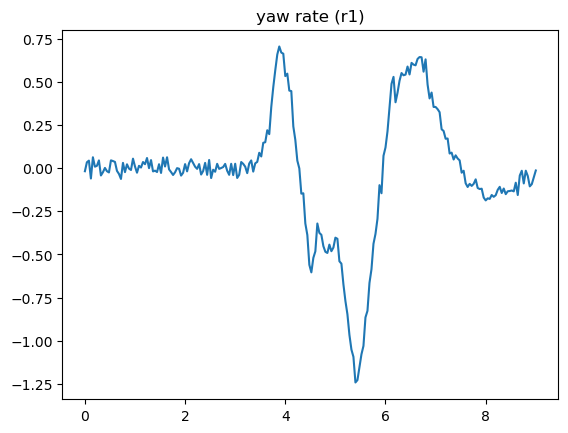

Text(0.5, 1.0, 'inertial acceleration (ay)')

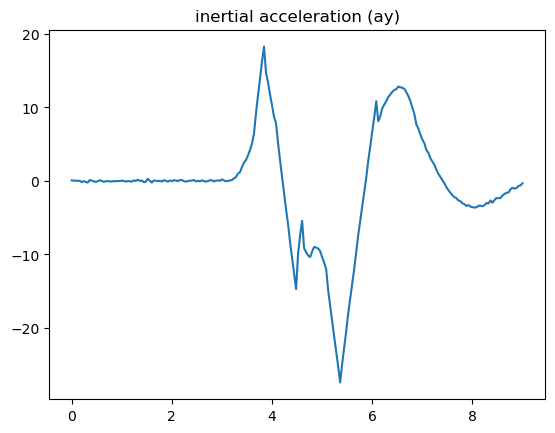

In [97]:
plt.plot(time, netOuput[0])
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time, netOuput[1])
plt.title("inertial acceleration (ay)")

---
---

# SYSTEM IDENTIFICATION USING **SIPPY**

In [98]:
from sippy import system_identification
from sippy import functionset as fset
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## Using input-output form

In [99]:
Id_ARMAXi = system_identification(outputs, inputs, 'ARMAX')
Id_ARMAXo = system_identification(outputs, inputs, 'ARMAX', ARMAX_mod = 'OPT')
Id_ARMAXr = system_identification(outputs, inputs, 'ARMAX', ARMAX_mod = 'RLLS')

In [100]:
# print(f"y[k] = {Id_ARMAXi.G}u[k] + {Id_ARMAXi.H}e[k]")
Id_ARMAXi.G

TransferFunction([[array([1.8621045]), array([-9.56939779e-06])], [array([137.20868151]), array([0.00032208])]], [[array([ 1.        , -0.55105063]), array([ 1.        , -0.55105063])], [array([1.        , 0.22613384]), array([1.        , 0.22613384])]], 1.0)

In [101]:
Yout_ARMAXi = Id_ARMAXi.Yid

In [102]:
r2_score(outputs[0], Yout_ARMAXi[0])

0.9988212000049416

In [103]:
r2_score(outputs[1], Yout_ARMAXi[1])

0.9987596854693793

In [104]:
Yout_ARMAXo = Id_ARMAXo.Yid

In [105]:
r2_score(outputs[0], Yout_ARMAXo[0])

0.9988296008794761

In [106]:
r2_score(outputs[1], Yout_ARMAXo[1])

0.999642637039171

In [107]:
Yout_ARMAXr = Id_ARMAXr.Yid

In [108]:
r2_score(outputs[0], Yout_ARMAXr[0])

0.9990199510373495

In [109]:
r2_score(outputs[1], Yout_ARMAXr[1])

0.999126496077912

---
---
---

## Using State-Space form

In [110]:
METHOD = [
    'N4SID',
    'CVA', 
    'MOESP', 
    'PARSIM-S', 
    'PARSIM-P', 
    'PARSIM-K'
    ]

lege = ['System']

In [111]:
sysId = system_identification(netOuput, inputs, METHOD[1])

In [112]:
from sippy import functionsetSIM as fsetSIM

In [113]:
x_id, y_id = fsetSIM.SS_lsim_process_form(sysId.A, sysId.B, sysId.C, sysId.D, inputs, sysId.x0)

In [114]:
sysId.A.shape

(20, 20)

Text(0.5, 1.0, 'yaw rate r')

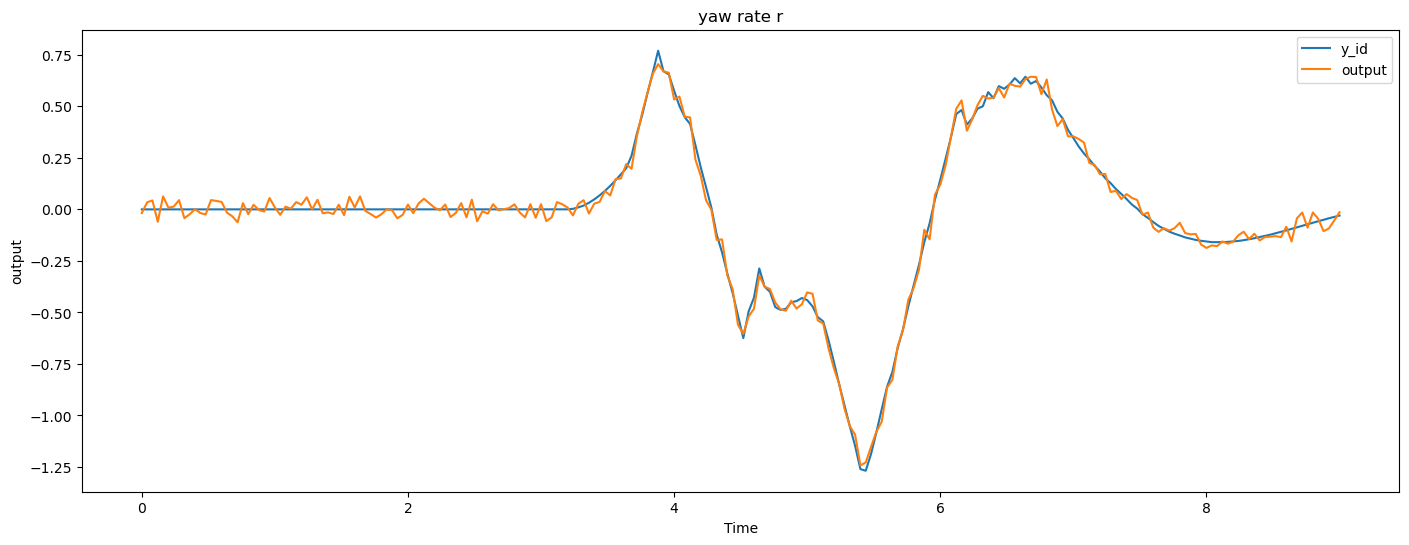

In [115]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id[0], label='y_id')
plt.plot(time, netOuput[0], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('yaw rate r')

Text(0.5, 1.0, 'inertial acceleration ay')

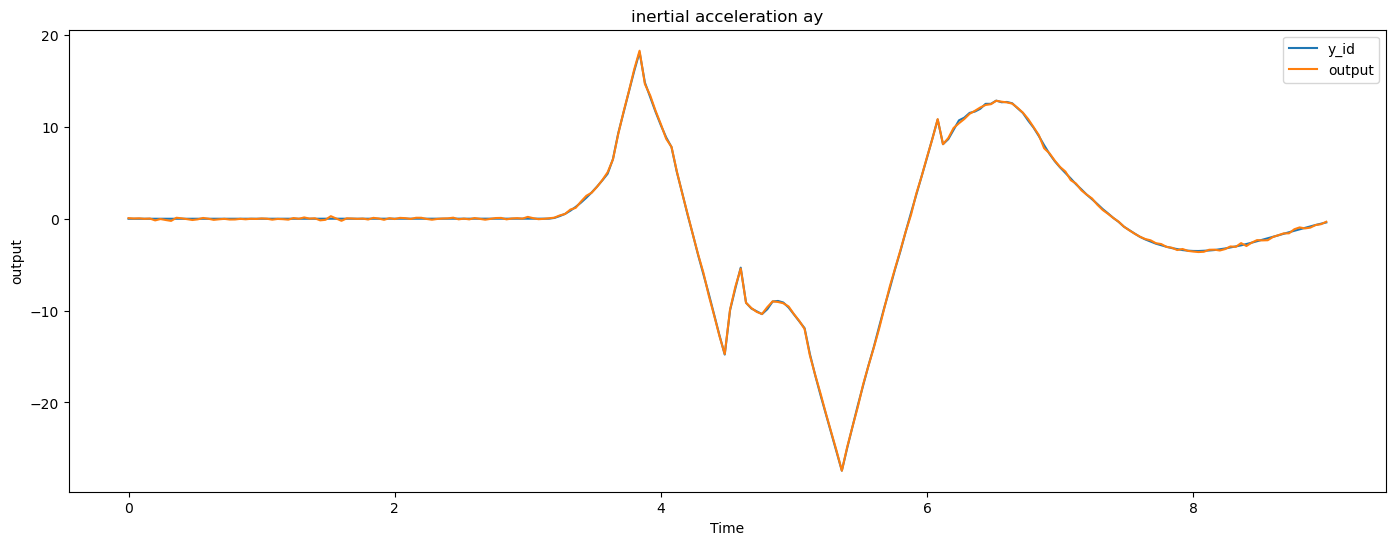

In [116]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id[1], label = 'y_id')
plt.plot(time, netOuput[1], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('inertial acceleration ay')

In [117]:
# for yaw rate
r2_score(netOuput[0], y_id[0])

0.9919370926264363

In [118]:
# for inertial acceleration ay
r2_score(netOuput[1], y_id[1])

0.9998144413761197

---

In [119]:
# for yaw rate
math.sqrt(mean_squared_error(netOuput[0], y_id[0]))

0.032510423075767785

In [120]:
# for inertial acceleration ay
math.sqrt(mean_squared_error(netOuput[0], y_id[0]))

0.032510423075767785